In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Investigate global and local spatial autocorrelation in the temperature dataset

This notebook contains analyses of global and local spatial autocorrelation in the temperature and population datasets. It also contains an investigation of how similar the 8 different temperature datasets are to each other.

The spatioal autocorrelation analyses in this notebook are done following https://geographicdata.science/book/notebooks/06_spatial_autocorrelation.html for global spatial autocorrelation, and https://geographicdata.science/book/notebooks/07_local_autocorrelation.html for local spatial autocorrelation.

# Global spatial autocorrelation

In [1]:
from dark.dimension import dimensionalIterator
from glob import glob
import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns
from pysal.viz import splot
from splot.esda import plot_moran
import contextily

import geopandas as gpd
import pandas as pd
from pysal.explore import esda
from pysal.lib import weights
from numpy.random import seed

import math
import statsmodels.formula.api as smf
from statsmodels.stats.multitest import multipletests
from collections import Counter

from giscode.common import NODATAVAL

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/barbara/opt/anaconda3/envs/310gis/lib/python3.10/site-packages/spaghetti/network.py:42: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(dep_msg, FutureWarning, stacklevel=1)


In [2]:
temps = gpd.read_file(
    "../240420-playing-with-interactive-maps/assets/all-data.json"
)

In [10]:
temps.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [9]:
temps

20220623    20220716    20220717    20220725    20220801    20220802  \
0       29.930923   29.941177   30.747829   34.343586   30.453880   29.613049   
1       32.880676   33.205387   34.049637   36.883175   33.171207   31.769819   
2     -999.000000 -999.000000 -999.000000 -999.000000 -999.000000   34.770840   
3       33.916336   32.385063   33.242985   37.327518   33.031067   32.074020   
4       30.628201   29.732679   31.113558   34.808437   30.467552   29.773695   
...           ...         ...         ...         ...         ...         ...   
20687   25.508005   24.554379   25.415720   29.589121   25.128605   24.219412   
20688   25.265326   24.209158   25.162786   29.397713   24.711607   24.250174   
20689   25.521677   24.072437   25.186712   29.387459   24.574886   24.458673   
20690   25.962603   24.349297   25.750685   29.677990   24.834656   24.516781   
20691 -999.000000 -999.000000 -999.000000 -999.000000   24.872253 -999.000000   

         20220809    20220810  perc_old  n_old  n_total  average_temp  \
0       29.014894   29.794203    -999.0 -999.0   -999.0     30.479942   
1       31.561319   32.945618    -999.0 -999.0   -999.0     33.308353   
2     -999.000000 -999.000000    -999.0 -999.0   -999.0     34.770840   
3       31.144321   33.301090    -999.0 -999.0   -999.0     33.302799   
4       28.997805   30.587183    -999.0 -999.0   -999.0     30.763639   
...           ...         ...       ...    ...      ...           ...   
20687   23.857101   25.128605    -999.0 -999.0   -999.0     25.425119   
20688   23.057285   24.930361    -999.0 -999.0   -999.0     25.123051   
20689   22.777008   24.824402    -999.0 -999.0   -999.0     25.100407   
20690   23.098301   25.145695    -999.0 -999.0   -999.0     25.417002   
20691   22.394190 -999.000000    -999.0 -999.0   -999.0     23.633223   

                                                geometry  
0      POLYGON ((8.53624 47.46802, 8.53757 47.46801, ...  
1      POLYGON ((8.53757 47.46801, 8.53889 47.46800, ...  
2      POLYGON ((8.54685 47.46792, 8.54818 47.46791, ...  
3      POLYGON ((8.54818 47.46791, 8.54950 47.46789, ...  
4      POLYGON ((8.54950 47.46789, 8.55083 47.46788, ...  
...                                                  ...  
20687  POLYGON ((8.50343 47.28663, 8.50475 47.28661, ...  
20688  POLYGON ((8.50475 47.28661, 8.50607 47.28660, ...  
20689  POLYGON ((8.50607 47.28660, 8.50739 47.28659, ...  
20690  POLYGON ((8.50739 47.28659, 8.50872 47.28658, ...  
20691  POLYGON ((8.51268 47.28654, 8.51400 47.28653, ...  

[20692 rows x 13 columns]

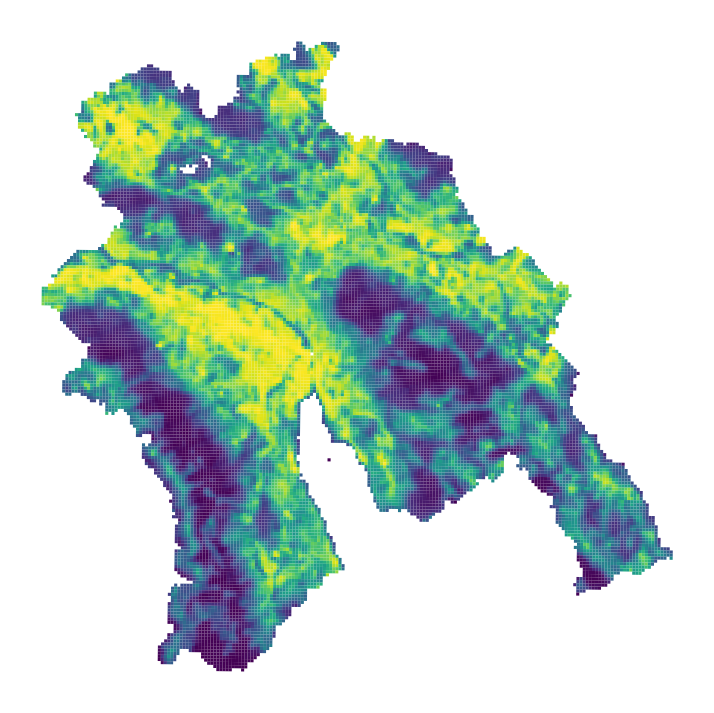

In [28]:
fig, ax = plt.subplots(1, figsize=(9, 9))
temps.plot(
    column="average_temp",
    cmap="viridis",
    scheme="quantiles",
    k=1000,
    #edgecolor="none",
    linewidth=0.0,
    alpha=1,
    legend=False,
    ax=ax,
)

ax.set_axis_off()

In [33]:
# Generate the weight matrix for the dataframe. I choose 8 neighbours, since that gives me a square around each grid cell.
# Then all in all, the side length of each square of neighbours is 300 metres. Given the layout of a town, where parks and roads
# are quite close together, I hope that a neigbourhood of that size will be ok.
w8 = weights.KNN.from_dataframe(temps, k=8)
# Row-standardization
w8.transform = "R"

# Try a larger neighbourhood
w15 = weights.KNN.from_dataframe(temps, k=15)
# Row-standardization
w15.transform = "R"

## Look at spatial lag

In [34]:
temps["average_temp_lag_8"] = weights.spatial_lag.lag_spatial(
    w8, temps["average_temp"]
)
temps["average_temp_lag_15"] = weights.spatial_lag.lag_spatial(
    w15, temps["average_temp"]
)

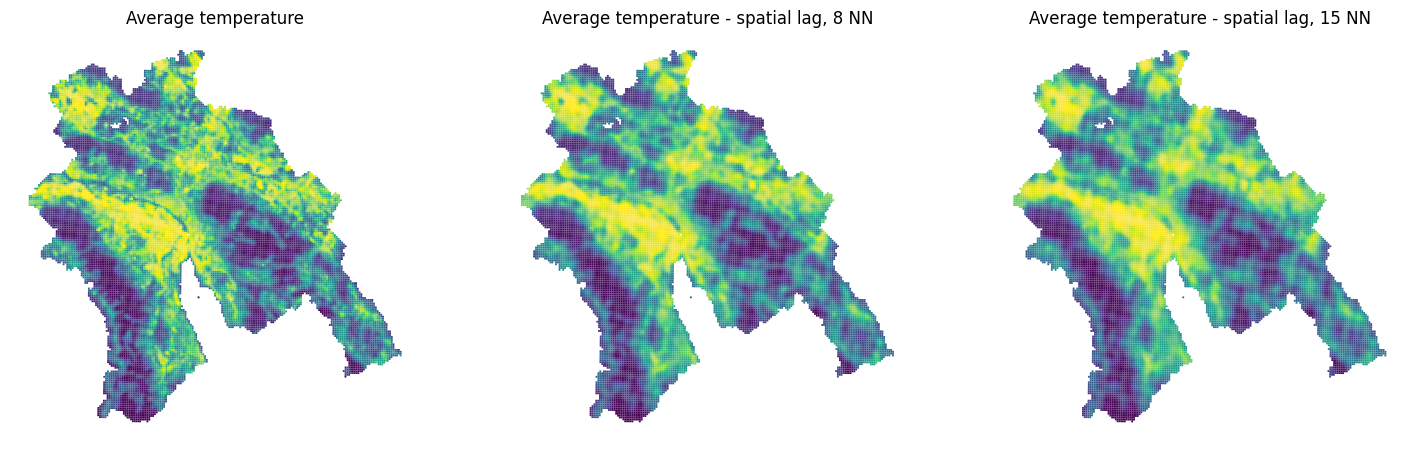

In [38]:
# Look at spatial lag

f, axs = plt.subplots(1, 3, figsize=(18, 6))
ax1, ax2, ax3 = axs

temps.plot(
    column="average_temp",
    cmap="viridis",
    scheme="quantiles",
    k=1000,
    edgecolor="white",
    linewidth=0.0,
    alpha=1,
    legend=False,
    ax=ax1,
)
ax1.set_axis_off()
ax1.set_title("Average temperature")

temps.plot(
    column="average_temp_lag_8",
    cmap="viridis",
    scheme="quantiles",
    k=1000,
    edgecolor="white",
    linewidth=0.0,
    alpha=1,
    legend=False,
    ax=ax2,
)
ax2.set_axis_off()
ax2.set_title("Average temperature - spatial lag, 8 NN")

temps.plot(
    column="average_temp_lag_15",
    cmap="viridis",
    scheme="quantiles",
    k=1000,
    edgecolor="white",
    linewidth=0.0,
    alpha=1,
    legend=False,
    ax=ax3,
)
ax3.set_axis_off()
ax3.set_title("Average temperature - spatial lag, 15 NN")

plt.show()

## Moran's I

In [54]:
# Standardise variables
temps["average_temp_std"] = temps["average_temp"] - temps["average_temp"].mean()
temps["average_temp_lag_std"] = weights.lag_spatial(
    w8, temps["average_temp_std"]
)

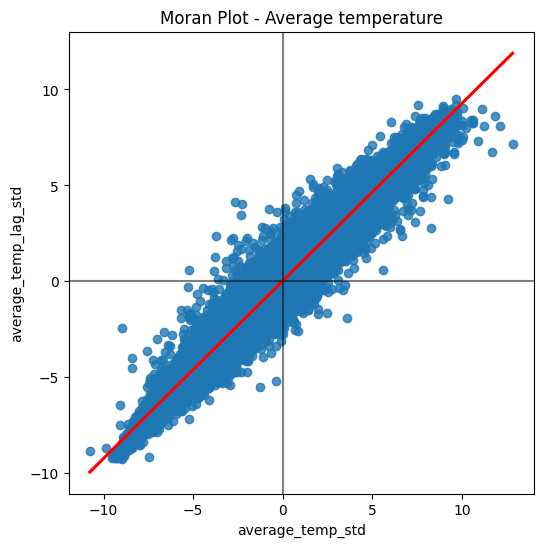

In [55]:
fig, ax = plt.subplots(1, figsize=(6, 6))
sns.regplot(
    x="average_temp_std",
    y="average_temp_lag_std",
    ci=95,
    data=temps,
    line_kws={"color": "r"},
)
ax.axvline(0, c="k", alpha=0.5)
ax.axhline(0, c="k", alpha=0.5)
ax.set_title("Moran Plot - Average temperature")
plt.show()

--> Suggests positive global spatial autocorrelation

In [56]:
moran = esda.moran.Moran(temps["average_temp"], w8)

In [58]:
moran.I, moran.p_sim

(0.9256961305734618, 0.001)

/Users/barbara/opt/anaconda3/envs/310gis/lib/python3.10/site-packages/splot/_viz_esda_mpl.py:354: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sbn.kdeplot(moran.sim, shade=shade, color=color, ax=ax, **kwargs)


(<Figure size 1000x400 with 2 Axes>,
 array([<Axes: title={'center': 'Reference Distribution'}, xlabel='Moran I: 0.93', ylabel='Density'>,
        <Axes: title={'center': 'Moran Scatterplot (0.93)'}, xlabel='Attribute', ylabel='Spatial Lag'>],
       dtype=object))

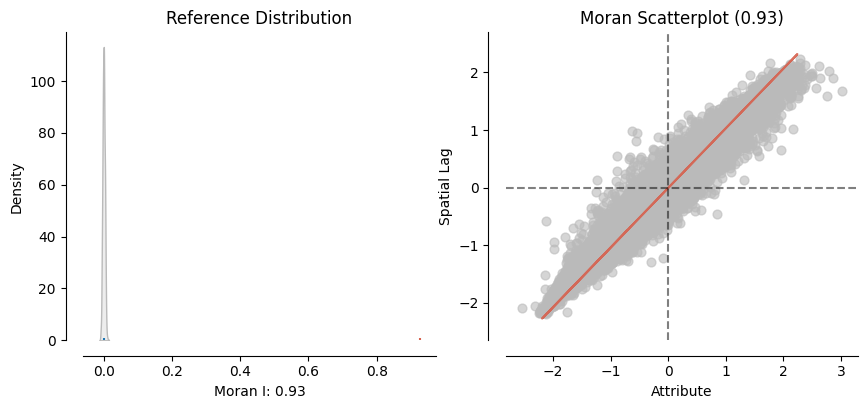

In [60]:
plot_moran(moran)

--> left plot: Distribution shows 999 repeats of randomising data and calculating Moran's I. The red line is the actual Moran's I.

### Calculate global spatial autocorrelation for each scene

In [61]:
def calculateMoransI(df, column):
    """
    Calculate Moran's I for a specific column in the dataframe.

    @param df: A GeoPandas dataframe.
    @param column: The column of data in df for which Moran's I should be calculated.
    """
    # Remove any empty cells
    dfNew = df.loc[df[column] != NODATAVAL]

    # Make weight matrix
    w8 = weights.KNN.from_dataframe(dfNew, k=8)
    # Row-standardization
    w8.transform = "R"
    
    # Calculate Moran's I
    moran = esda.moran.Moran(dfNew[column], w8)

    return moran

In [75]:
print("Column\tMoran's I (95% CI)\tp-value")
for column in ('20220623', '20220716', '20220717', '20220725', '20220801', '20220802',
               '20220809', '20220810', 'average_temp', 'perc_old', 'n_old', 'n_total'):
    m = calculateMoransI(temps, column)
    ci_lower = m.I - 1.96 * np.sqrt(m.VI_sim)
    ci_upper = m.I + 1.96 * np.sqrt(m.VI_sim)
    print(f'{column}:\t{m.I:.3f} ({ci_lower:.3f}, {ci_upper:.3f})\t{m.p_sim:.3f}')

Column	Moran's I (95% CI)	p-value
20220623:	0.932 (0.925, 0.939)	0.001
20220716:	0.921 (0.914, 0.927)	0.001
20220717:	0.922 (0.915, 0.929)	0.001
20220725:	0.914 (0.908, 0.921)	0.001
20220801:	0.908 (0.902, 0.915)	0.001
20220802:	0.917 (0.911, 0.924)	0.001
20220809:	0.911 (0.904, 0.917)	0.001
20220810:	0.907 (0.900, 0.914)	0.001
average_temp:	0.926 (0.919, 0.932)	0.001


/Users/barbara/opt/anaconda3/envs/310gis/lib/python3.10/site-packages/libpysal/weights/distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 5 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


perc_old:	0.153 (0.143, 0.164)	0.001


/Users/barbara/opt/anaconda3/envs/310gis/lib/python3.10/site-packages/libpysal/weights/distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 5 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


n_old:	0.207 (0.196, 0.218)	0.001
n_total:	0.417 (0.406, 0.428)	0.001


/Users/barbara/opt/anaconda3/envs/310gis/lib/python3.10/site-packages/libpysal/weights/distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 5 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


--> Significant global spatial autocorrelation in all columns, not surprisingly less for the population data. I wonder how much those values should be trusted anyway, since the cells aren't all connected.

# Local spatial autocorrelation

In [83]:
go_i_star = esda.getisord.G_Local(temps["average_temp"], w8, star=True)

/Users/barbara/opt/anaconda3/envs/310gis/lib/python3.10/site-packages/esda/getisord.py:615: UserWarning: Gi* requested, but (a) weights are already row-standardized, (b) no weights are on the diagonal, and (c) no default value supplied to star. Assuming that the self-weight is equivalent to the maximum weight in the row. To use a different default (like, .5), set `star=.5`, or use libpysal.weights.fill_diagonal() to set the diagonal values of your weights matrix and use `star=None` in Gi_Local.
  warnings.warn(


In [102]:
go_i_star.p_sim, go_i_star.Zs

(array([0.001, 0.002, 0.004, ..., 0.001, 0.001, 0.001]),
 array([-1.03607023, -0.77066205, -0.75476935, ..., -1.12189084,
        -1.11553376, -1.11553376]))

In [3]:
# Calculate getis ord Gi* for all relevant columns and collect results
for i, column in enumerate(('20220623', '20220716', '20220717', '20220725', '20220801', '20220802',
                            '20220809', '20220810', 'average_temp', 'perc_old', 'n_old', 'n_total')):    
    # Local autocorrelation
    dfNew = temps.loc[temps[column] != NODATAVAL]
    # Make weight matrix
    w = weights.KNN.from_dataframe(dfNew, k=8)
    # Row-standardization
    w.transform = "R"
    # Calculate G statistic
    go_i_star = esda.getisord.G_Local(dfNew[column], w, star=True)

    result = []
    for p, z in zip(go_i_star.p_sim, go_i_star.Zs):
        if p > 0.05:
            result.append('ns')
        else:
            if z > 0:
                result.append('pos')
            elif z <= 0:
                result.append('neg')

    colName = column + '_go_i_star'
    resultDf = pd.DataFrame({
        colName: result
    }, index=dfNew.index)

    temps = temps.join(resultDf)


/Users/barbara/opt/anaconda3/envs/310gis/lib/python3.10/site-packages/esda/getisord.py:615: UserWarning: Gi* requested, but (a) weights are already row-standardized, (b) no weights are on the diagonal, and (c) no default value supplied to star. Assuming that the self-weight is equivalent to the maximum weight in the row. To use a different default (like, .5), set `star=.5`, or use libpysal.weights.fill_diagonal() to set the diagonal values of your weights matrix and use `star=None` in Gi_Local.
  warnings.warn(
/Users/barbara/opt/anaconda3/envs/310gis/lib/python3.10/site-packages/esda/getisord.py:615: UserWarning: Gi* requested, but (a) weights are already row-standardized, (b) no weights are on the diagonal, and (c) no default value supplied to star. Assuming that the self-weight is equivalent to the maximum weight in the row. To use a different default (like, .5), set `star=.5`, or use libpysal.weights.fill_diagonal() to set the diagonal values of your weights matrix and use `star=No

In [96]:
def plotGIStarMap(df, column, ax):
    """
    Plot a map showing Getis Ord Gi* values
    """    
    # Plot non-significant clusters
    ns = df.loc[df[column] == "ns", "geometry"]
    ns.plot(ax=ax, color="lightgrey", edgecolor='white', linewidth=0.0)
    # Plot positive clusters
    hh = df.loc[df[column] == "pos", "geometry"]
    hh.plot(ax=ax, color="red", edgecolor='white', linewidth=0.0)
    # Plot negative clusters
    ll = df.loc[df[column] == "neg", "geometry"]
    ll.plot(ax=ax, color="blue", edgecolor='white', linewidth=0.0)

    ax.set_title(column[0:-10])
    ax.set_axis_off()
    
    return ax

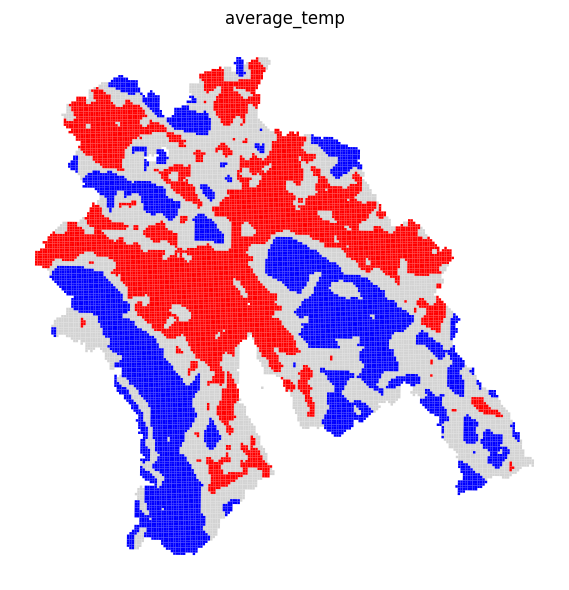

In [128]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax = plotGIStarMap(temps, 'average_temp_go_i_star', ax)

plt.tight_layout()

plt.show()

20220623


/Users/barbara/opt/anaconda3/envs/310gis/lib/python3.10/site-packages/mapclassify/classifiers.py:1592: UserWarning: Not enough unique values in array to form 1000 classes. Setting k to 994.
  self.bins = quantile(y, k=k)


20220716


/Users/barbara/opt/anaconda3/envs/310gis/lib/python3.10/site-packages/mapclassify/classifiers.py:1592: UserWarning: Not enough unique values in array to form 1000 classes. Setting k to 994.
  self.bins = quantile(y, k=k)


20220717


/Users/barbara/opt/anaconda3/envs/310gis/lib/python3.10/site-packages/mapclassify/classifiers.py:1592: UserWarning: Not enough unique values in array to form 1000 classes. Setting k to 993.
  self.bins = quantile(y, k=k)


20220725


/Users/barbara/opt/anaconda3/envs/310gis/lib/python3.10/site-packages/mapclassify/classifiers.py:1592: UserWarning: Not enough unique values in array to form 1000 classes. Setting k to 994.
  self.bins = quantile(y, k=k)


20220801


/Users/barbara/opt/anaconda3/envs/310gis/lib/python3.10/site-packages/mapclassify/classifiers.py:1592: UserWarning: Not enough unique values in array to form 1000 classes. Setting k to 975.
  self.bins = quantile(y, k=k)


20220802


/Users/barbara/opt/anaconda3/envs/310gis/lib/python3.10/site-packages/mapclassify/classifiers.py:1592: UserWarning: Not enough unique values in array to form 1000 classes. Setting k to 994.
  self.bins = quantile(y, k=k)


20220809


/Users/barbara/opt/anaconda3/envs/310gis/lib/python3.10/site-packages/mapclassify/classifiers.py:1592: UserWarning: Not enough unique values in array to form 1000 classes. Setting k to 992.
  self.bins = quantile(y, k=k)


20220810


/Users/barbara/opt/anaconda3/envs/310gis/lib/python3.10/site-packages/mapclassify/classifiers.py:1592: UserWarning: Not enough unique values in array to form 1000 classes. Setting k to 993.
  self.bins = quantile(y, k=k)


average_temp
perc_old


/Users/barbara/opt/anaconda3/envs/310gis/lib/python3.10/site-packages/mapclassify/classifiers.py:1592: UserWarning: Not enough unique values in array to form 1000 classes. Setting k to 293.
  self.bins = quantile(y, k=k)


n_old


/Users/barbara/opt/anaconda3/envs/310gis/lib/python3.10/site-packages/mapclassify/classifiers.py:1592: UserWarning: Not enough unique values in array to form 1000 classes. Setting k to 54.
  self.bins = quantile(y, k=k)


n_total


/Users/barbara/opt/anaconda3/envs/310gis/lib/python3.10/site-packages/mapclassify/classifiers.py:1592: UserWarning: Not enough unique values in array to form 1000 classes. Setting k to 209.
  self.bins = quantile(y, k=k)


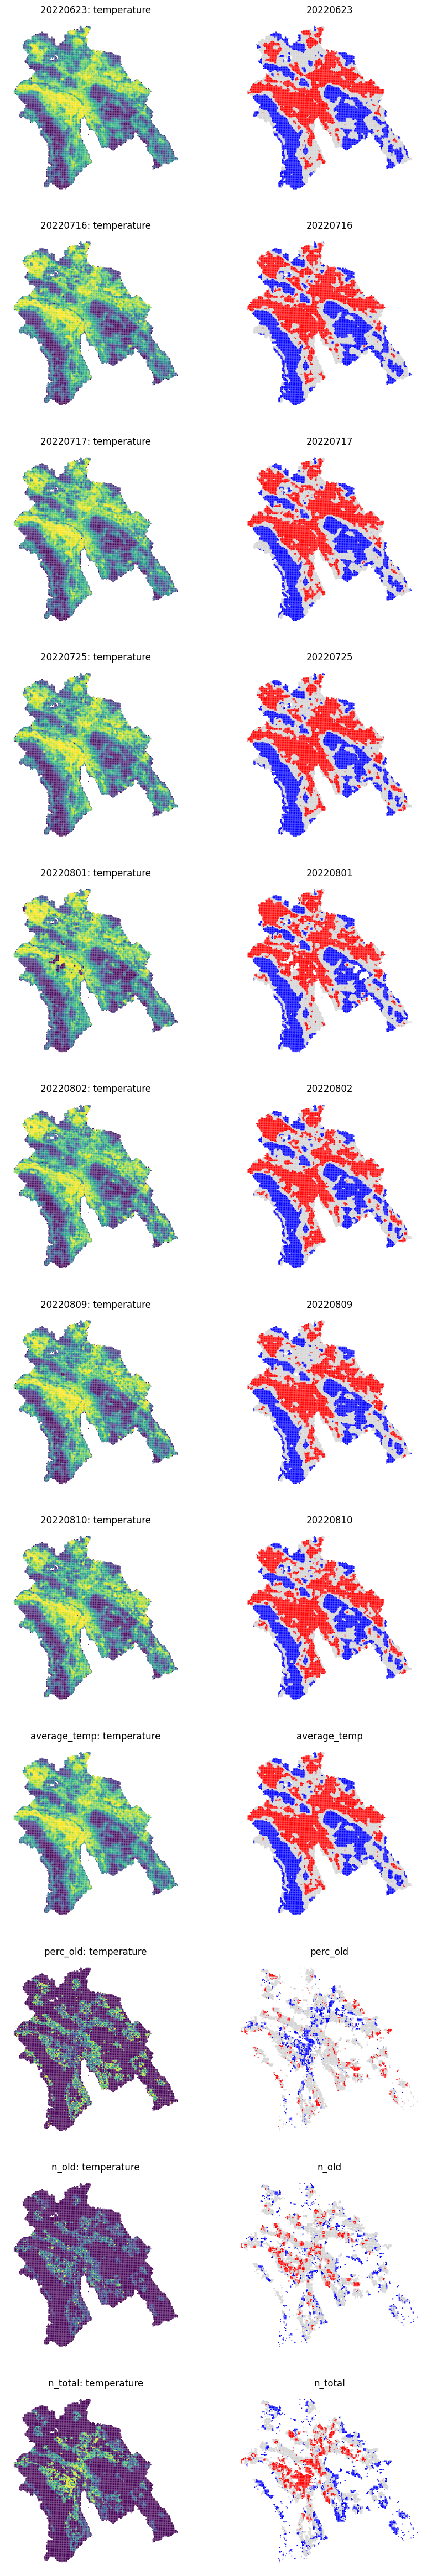

In [98]:
fig, axs = plt.subplots(12, 2, figsize=(10, 60))

for i, column in enumerate(('20220623', '20220716', '20220717', '20220725', '20220801', '20220802',
                            '20220809', '20220810', 'average_temp', 'perc_old', 'n_old', 'n_total')):
    ax = axs[i][0]
    print(column)
    # Plot normal temperature image
    temps.plot(
        column=column,
        cmap="viridis",
        scheme="quantiles",
        k=1000,
        edgecolor="white",
        linewidth=0.0,
        alpha=1,
        legend=False,
        ax=ax,
    )
    ax.set_axis_off()
    ax.set_title(f'{column}: temperature')

    # Local autocorrelation
    ax1 = axs[i][1]
    ax1 = plotGIStarMap(temps, column + '_go_i_star', ax1)
    

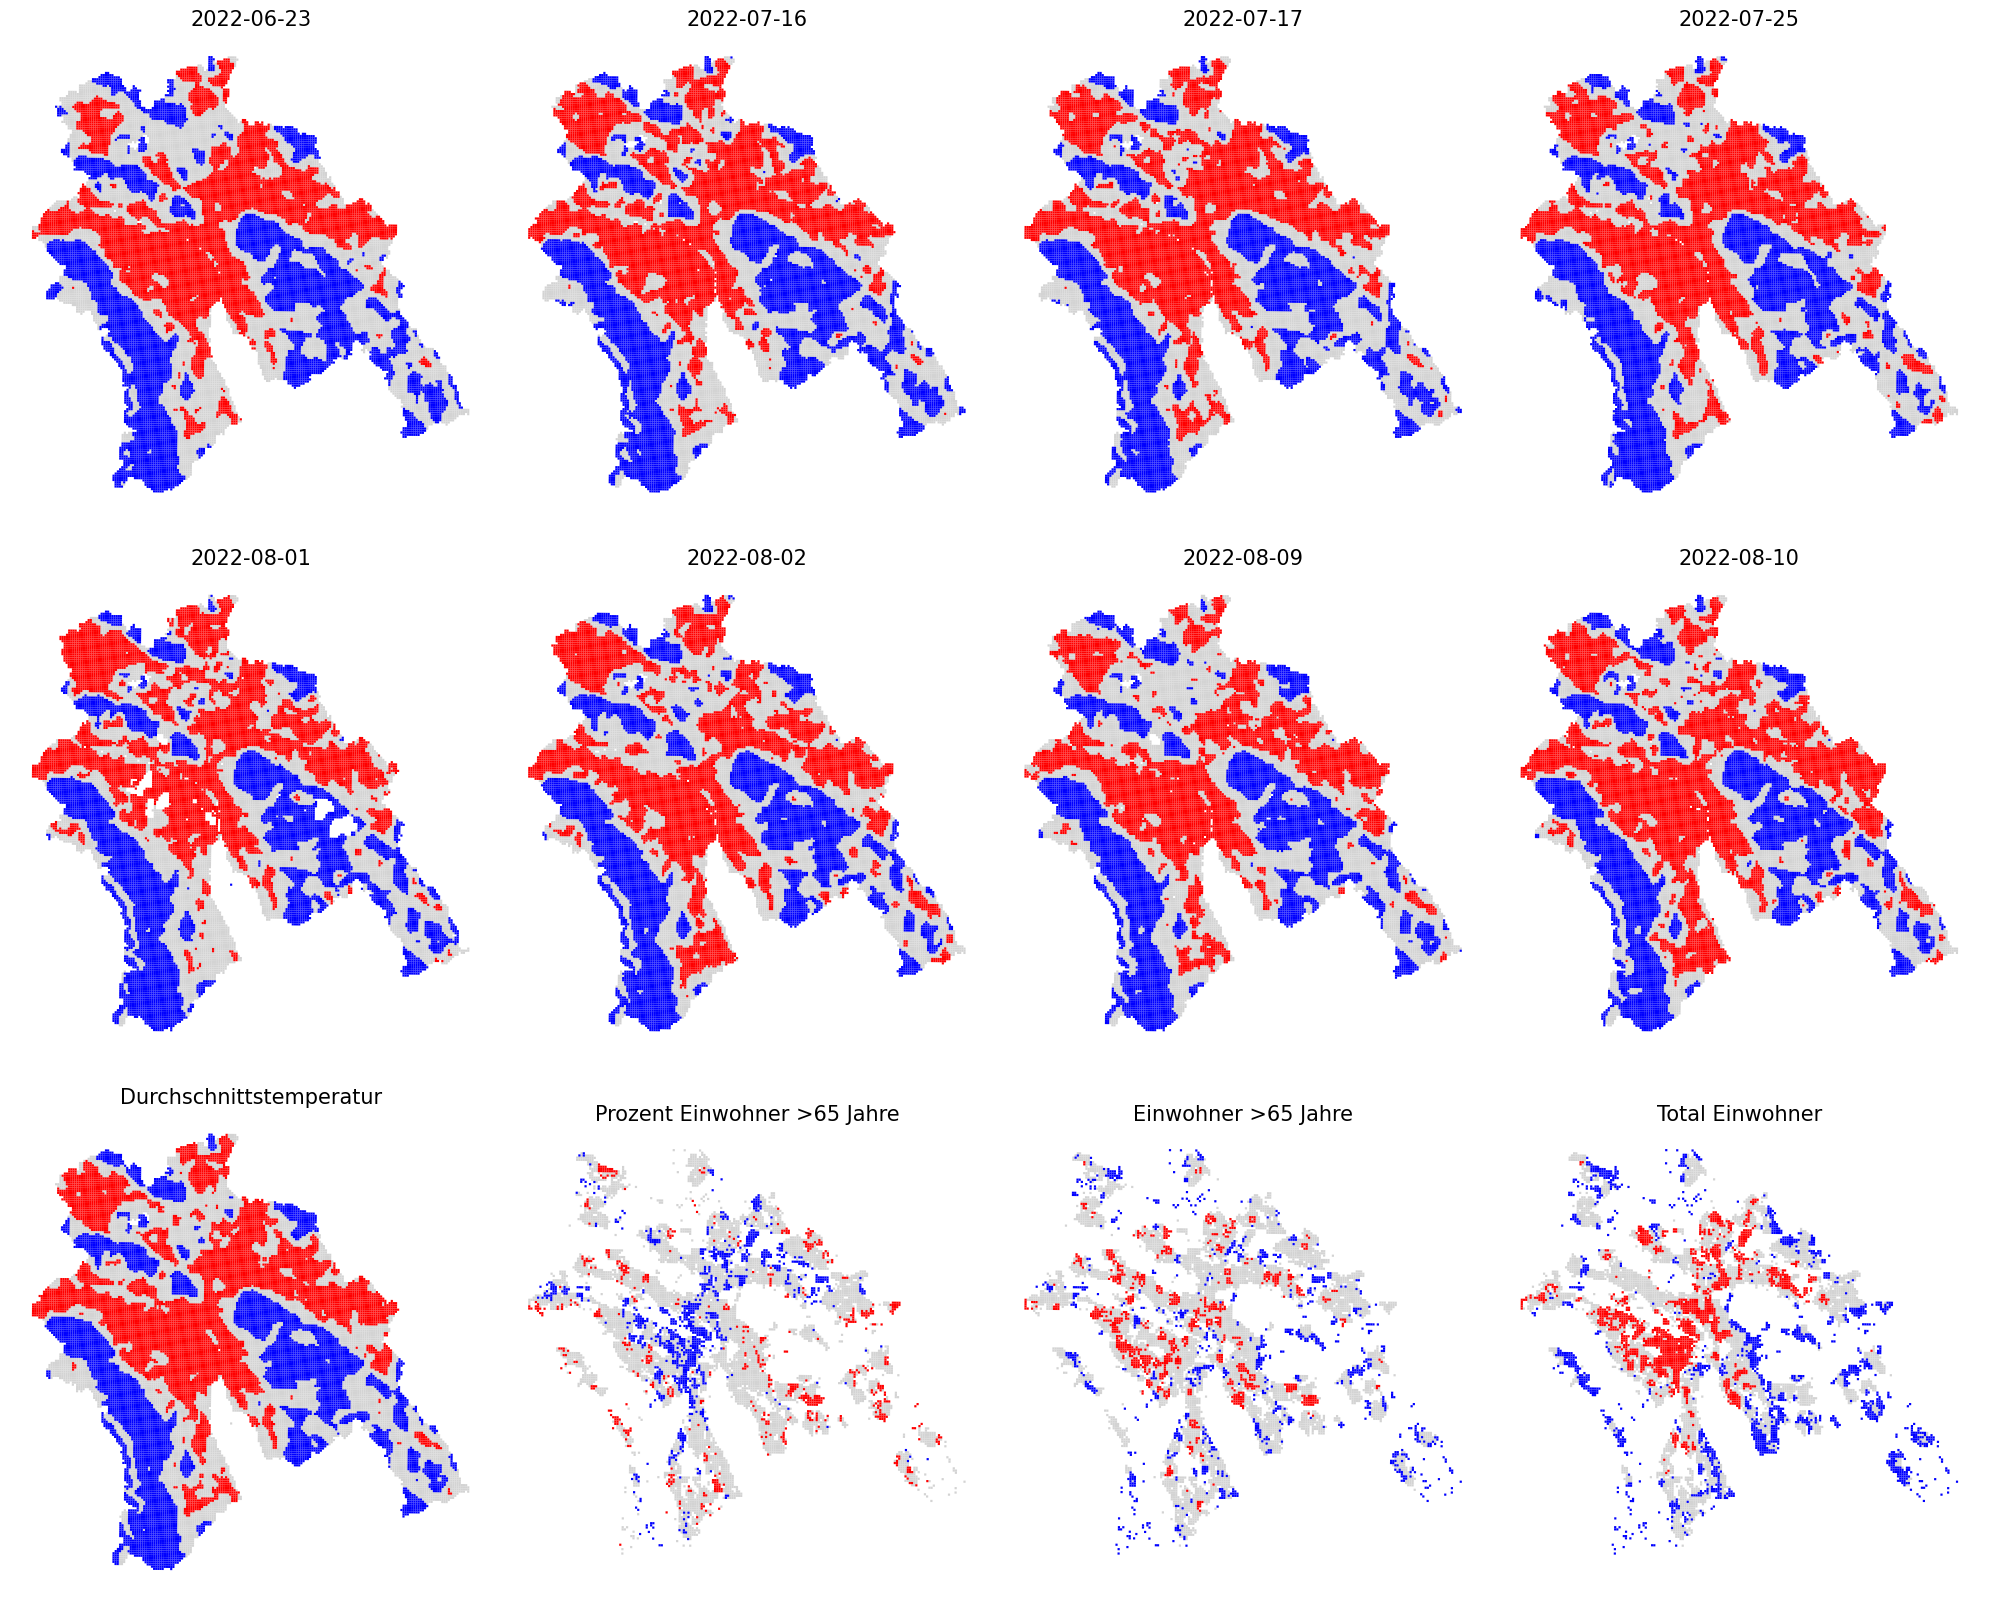

In [97]:
fig, ax = plt.subplots(3, 4, figsize = (20, 16.5))

titles = {
    '20220623': '2022-06-23', 
    '20220716': '2022-07-16', 
    '20220717': '2022-07-17', 
    '20220725': '2022-07-25', 
    '20220801': '2022-08-01', 
    '20220802': '2022-08-02',
    '20220809': '2022-08-09', 
    '20220810': '2022-08-10', 
    'average_temp': 'Durchschnittstemperatur', 
    'perc_old': 'Prozent Einwohner >65 Jahre', 
    'n_old': 'Einwohner >65 Jahre', 
    'n_total': 'Total Einwohner'
}

coords = dimensionalIterator((3, 4))
for i, column in enumerate(('20220623', '20220716', '20220717', '20220725', '20220801', '20220802',
                            '20220809', '20220810', 'average_temp', 'perc_old', 'n_old', 'n_total')):
    row, col = next(coords)

    ax[row][col] = plotGIStarMap(temps, column + '_go_i_star', ax[row][col])
    ax[row][col].set_title(titles[column], fontsize=15)

plt.tight_layout()
plt.savefig('gi-panel.pdf')

--> Percentage of old people is not a good measure, if we want to protect as many people as possible.

## Are hotspots in the same place?

In [393]:
tempsG = temps[['20220623_go_i_star', '20220716_go_i_star', '20220717_go_i_star',
       '20220725_go_i_star', '20220801_go_i_star', '20220802_go_i_star',
       '20220809_go_i_star', '20220810_go_i_star']]

tempsG['num_pos'] = tempsG.apply(lambda row: row.str.count('pos').sum(), axis=1)

/var/folders/z3/x6qjmllx6314vnr7cktm58680000gn/T/ipykernel_6924/552993535.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tempsG['num_pos'] = tempsG.apply(lambda row: row.str.count('pos').sum(), axis=1)


In [394]:
tempsG

20220623_go_i_star 20220716_go_i_star 20220717_go_i_star  \
0                    neg                neg                neg   
1                    neg                neg                neg   
2                    NaN                NaN                NaN   
3                     ns                 ns                 ns   
4                     ns                 ns                 ns   
...                  ...                ...                ...   
20687                neg                neg                neg   
20688                neg                neg                neg   
20689                neg                neg                neg   
20690                neg                neg                neg   
20691                NaN                NaN                NaN   

      20220725_go_i_star 20220801_go_i_star 20220802_go_i_star  \
0                    neg                 ns                neg   
1                    neg                 ns                neg   
2                    NaN                NaN                pos   
3                     ns                pos                 ns   
4                     ns                 ns                 ns   
...                  ...                ...                ...   
20687                neg                neg                neg   
20688                neg                neg                neg   
20689                neg                neg                neg   
20690                neg                neg                neg   
20691                NaN                neg                NaN   

      20220809_go_i_star 20220810_go_i_star  num_pos  
0                     ns                neg      0.0  
1                     ns                neg      0.0  
2                    NaN                NaN      1.0  
3                    pos                 ns      2.0  
4                     ns                 ns      0.0  
...                  ...                ...      ...  
20687                neg                neg      0.0  
20688                neg                neg      0.0  
20689                neg                neg      0.0  
20690                neg                neg      0.0  
20691                neg                NaN      0.0  

[20692 rows x 9 columns]

In [398]:
tempsG.loc[tempsG.num_pos > 0].shape

(9163, 9)

In [405]:
totalPos = tempsG.loc[tempsG.num_pos > 0].shape[0]

c = Counter(tempsG['num_pos'])
print(sum(c.values()) - 11529)

for i in range(9):
    print(i, c[i], c[i] / totalPos * 100)

9163
0 11529 125.82123758594346
1 732 7.988650005456728
2 619 6.755429444505075
3 601 6.558987231256139
4 675 7.366582996835097
5 515 5.62042999017789
6 644 7.028265851795264
7 1162 12.681436210847977
8 4215 46.00021826912583


--> So about 46% of all pixels that have been designated a hotspot in any of the 8 scenes are designated to be a hotspot in all scenes. ~66% are designated hotspots in 6 or more scenes.

## Percentage of population in ZH that live in temperature hotspots:

In [239]:
totalPop = sum(temps.loc[temps.n_total != NODATAVAL]['n_total'])
totalOld = sum(temps.loc[temps.n_old != NODATAVAL]['n_old'])

totalPopHot = sum(temps.loc[(temps.n_total != NODATAVAL) & (temps.average_temp_go_i_star == 'pos')]['n_total'])
totalOldHot = sum(temps.loc[(temps.n_old != NODATAVAL) & (temps.average_temp_go_i_star == 'pos')]['n_old'])

print(totalPop, totalPopHot, totalPopHot / totalPop * 100, totalOld, totalOldHot, totalOldHot / totalOld * 100)

642303.0 459507.0 71.54053460749833 96192.0 62237.0 64.70080671989355


39.38593521118164


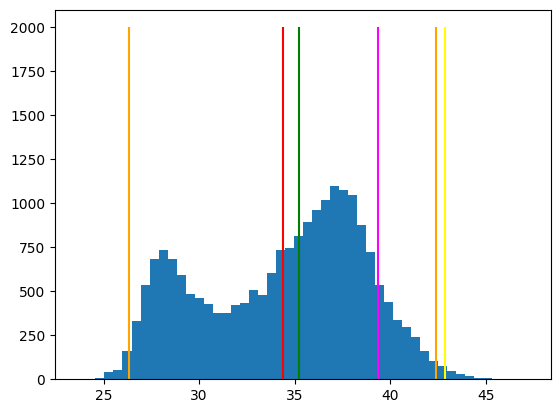

In [278]:
fig, ax = plt.subplots()

t = temps.loc[temps.average_temp != NODATAVAL]['average_temp']

print(np.quantile(t, q=0.90))

ax.hist(t, bins=50)
ax.vlines(np.mean(t), 0, 2000, color='red')
ax.vlines(np.median(t), 0, 2000, color='green')
ax.vlines(np.percentile(t, q=1), 0, 2000, color='orange')
ax.vlines(np.percentile(t, q=99), 0, 2000, color='orange')
ax.vlines(np.mean(t) + 2 * np.std(t), 0, 2000, color='yellow')
ax.vlines(np.quantile(t, q=0.90), 0, 2000, color='magenta')


26.0
12.511966701352758


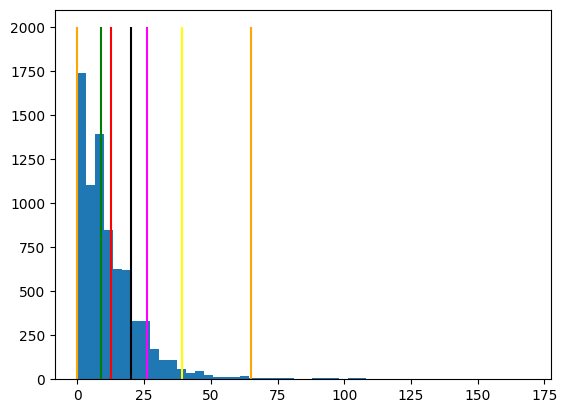

In [6]:
fig, ax = plt.subplots()

t = temps.loc[temps.n_old != NODATAVAL]['n_old']

print(np.quantile(t, q=0.90))

ax.hist(t, bins=50)
ax.vlines(np.mean(t), 0, 2000, color='red')
ax.vlines(np.median(t), 0, 2000, color='green')
ax.vlines(np.percentile(t, q=1), 0, 2000, color='orange')
ax.vlines(np.percentile(t, q=99), 0, 2000, color='orange')
ax.vlines(np.mean(t) + 2 * np.std(t), 0, 2000, color='yellow')
ax.vlines(np.quantile(t, q=0.90), 0, 2000, color='magenta')
print(np.mean(t))

ax.vlines(20, 0, 2000, color='black')

26.0
39.38593595450002


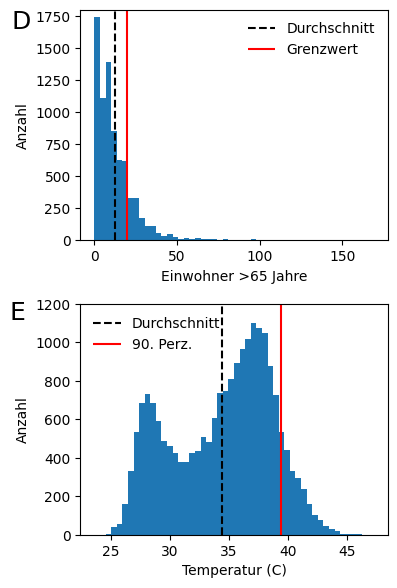

In [94]:
fig, axs = plt.subplots(2, 1, figsize=(4.1, 6))

ax = axs[0]

t = temps.loc[temps.n_old != NODATAVAL]['n_old']

print(np.quantile(t, q=0.90))

ax.hist(t, bins=50)
ax.vlines(np.mean(t), 0, 2000, linestyle='--', color='black', label='Durchschnitt')
ax.vlines(20, 0, 2000, color='red', label='Grenzwert')

ax.legend(frameon=False)

ax.set_ylim(0, 1800)
ax.set_ylabel('Anzahl')
ax.set_xlabel('Einwohner >65 Jahre')
ax.text(-50, 1650, 'D', fontsize=18)

ax = axs[1]
t = temps.loc[temps.average_temp != NODATAVAL]['average_temp']

print(np.quantile(t, q=0.90))

ax.hist(t, bins=50)
ax.vlines(np.mean(t), 0, 2000, linestyle='--', color='black', label='Durchschnitt')
ax.vlines(np.quantile(t, q=0.90), 0, 2000, color='red', label='90. Perz.')

ax.legend(frameon=False)

ax.set_ylim(0, 1200)
ax.set_ylabel('Anzahl')
ax.set_xlabel('Temperatur (C)')
ax.text(16.5, 1120, 'E', fontsize=18)

plt.tight_layout()

plt.savefig('histograms.pdf')

### Plot areas that are hot spots for temperature and for n_old

Total: Total: 642303.0 96192.0 7688
Protected A: Total: 91847.0 15443.0 680 22.71029411764706
Protected B: Total: 170321.0 33746.0 1044 32.32375478927203
Protected C: Total: 58745.0 9456.0 297 31.838383838383837


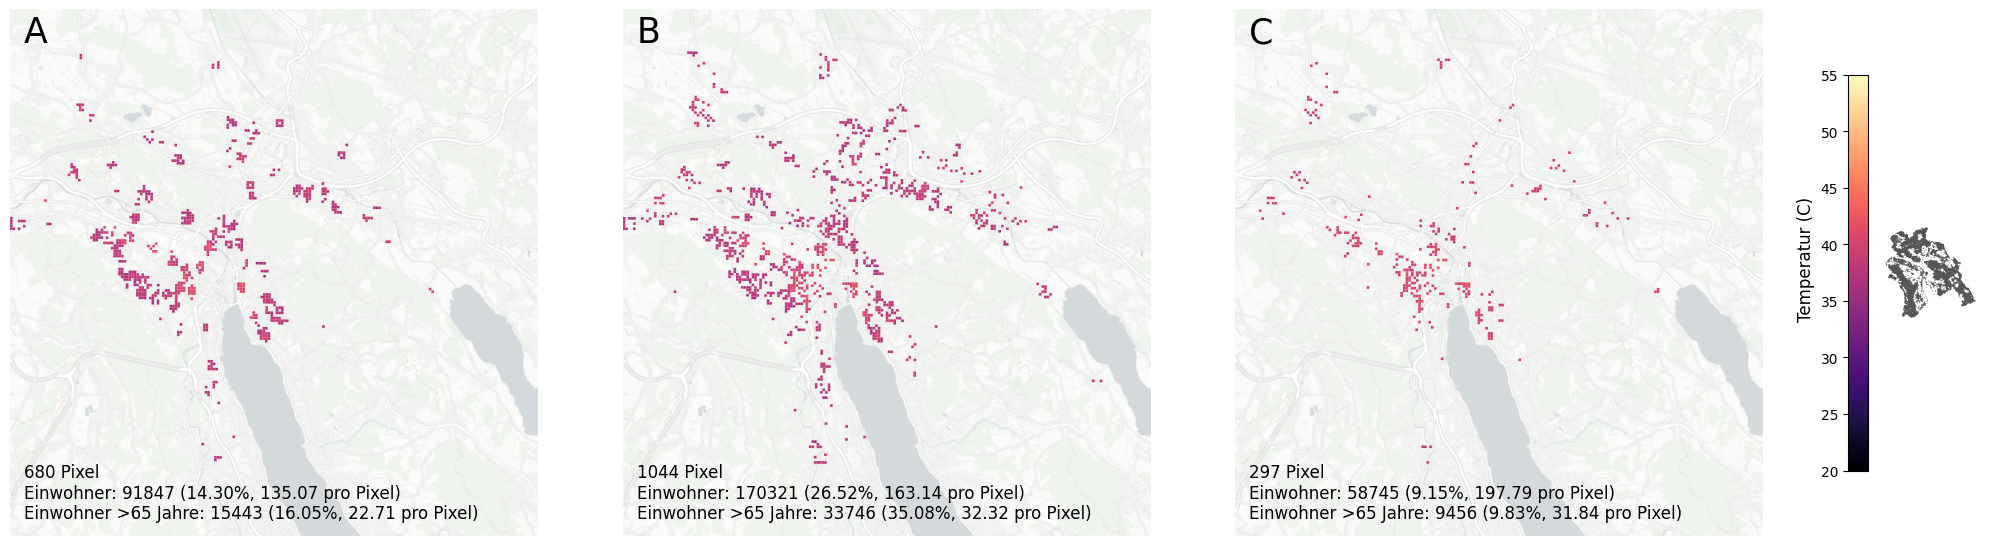

In [101]:
fig, axs = plt.subplots(1, 4, figsize=(20, 6), gridspec_kw={'width_ratios': [2, 2, 2, 0.5]})

# Plot first figure:
ax = axs[0]
newDf = temps.loc[(temps.n_old_go_i_star == 'pos') & (temps.average_temp_go_i_star == 'pos')]

print('Total: Total:', sum(temps.loc[temps.n_total != -999]['n_total']), sum(temps.loc[temps.n_total != -999]['n_old']), temps.loc[temps.n_total != -999].shape[0])
print('Protected A: Total:', sum(newDf['n_total']), sum(newDf['n_old']), newDf.shape[0], sum(newDf['n_old']) / newDf.shape[0])

newDf = newDf.to_crs(epsg=3857)

newDf.plot(
    column='average_temp',
    legend=False,
    cmap='magma',
    vmin=20,
    vmax=55,
    alpha=1,
    ax=ax,
)

p = newDf.shape[0]
t = sum(newDf['n_total'])
to = sum(newDf['n_old'])
axs[0].text(938933.05516891, 5989968.90757498, f"{p} Pixel\nEinwohner: {int(t)} ({t / 642303.0 * 100:.2f}%, {t / p:.2f} pro Pixel)\nEinwohner >65 Jahre: {int(to)} ({to / 96192.0 * 100:.2f}%, {to / p:.2f} pro Pixel)", 
            fontsize=12)

ax.set_xlim(938133.05516891, 968175.29928545)
ax.set_ylim(5988968.90757498, 6018952.4745305)

contextily.add_basemap(
        ax,
        crs=newDf.crs.to_string(),
        source='https://cartodb-basemaps-{s}.global.ssl.fastly.net/light_nolabels/{z}/{x}/{y}.png'
        #source=contextily.providers.Esri.WorldTerrain,
    )
ax.set_axis_off()

# Plot second figure:
ax = axs[1]
newDf = temps.loc[(temps.n_old >= 20) & (temps.average_temp_go_i_star == 'pos')]
print('Protected B: Total:', sum(newDf['n_total']), sum(newDf['n_old']), newDf.shape[0], sum(newDf['n_old']) / newDf.shape[0])

newDf = newDf.to_crs(epsg=3857)

newDf.plot(
    column='average_temp',
    legend=False,
    cmap='magma',
    vmin=20,
    vmax=55,
    alpha=1,
    ax=ax
)

p = newDf.shape[0]
t = sum(newDf['n_total'])
to = sum(newDf['n_old'])
axs[1].text(938933.05516891, 5989968.90757498, f"{p} Pixel\nEinwohner: {int(t)} ({t / 642303.0 * 100:.2f}%, {t / p:.2f} pro Pixel)\nEinwohner >65 Jahre: {int(to)} ({to / 96192.0 * 100:.2f}%, {to / p:.2f} pro Pixel)", 
            fontsize=12)

ax.set_xlim(938133.05516891, 968175.29928545)
ax.set_ylim(5988968.90757498, 6018952.4745305)

contextily.add_basemap(
        ax,
        crs=newDf.crs.to_string(),
        source='https://cartodb-basemaps-{s}.global.ssl.fastly.net/light_nolabels/{z}/{x}/{y}.png',
        # reset_extent=False
        #source=contextily.providers.Esri.WorldTerrain,
    )
ax.set_axis_off()

# Plot third figure:
ax = axs[2]
newDf = temps.loc[(temps.n_old >= 20) & (temps.average_temp > 39)]
print('Protected C: Total:', sum(newDf['n_total']), sum(newDf['n_old']), newDf.shape[0], sum(newDf['n_old']) / newDf.shape[0])

newDf = newDf.to_crs(epsg=3857)

newDf.plot(
    column='average_temp',
    legend=False,
    cmap='magma',
    vmin=20,
    vmax=55,
    alpha=1,
    ax=ax
)

p = newDf.shape[0]
t = sum(newDf['n_total'])
to = sum(newDf['n_old'])
axs[2].text(938933.05516891, 5989968.90757498, f"{p} Pixel\nEinwohner: {int(t)} ({t / 642303.0 * 100:.2f}%, {t / p:.2f} pro Pixel)\nEinwohner >65 Jahre: {int(to)} ({to / 96192.0 * 100:.2f}%, {to / p:.2f} pro Pixel)", 
            fontsize=12)

ax.set_xlim(938133.05516891, 968175.29928545)
ax.set_ylim(5988968.90757498, 6018952.4745305)

contextily.add_basemap(
        ax,
        crs=newDf.crs.to_string(),
        source='https://cartodb-basemaps-{s}.global.ssl.fastly.net/light_nolabels/{z}/{x}/{y}.png',
        # reset_extent=False
        #source=contextily.providers.Esri.WorldTerrain,
    )
ax.set_axis_off()

# Plot third figure
temps.loc[temps.n_total == NODATAVAL].to_crs(epsg=3857).plot(
    column='n_total',
    legend=True,
    legend_kwds={'location': 'left'},
    cmap='magma',
    vmin=20,
    vmax=55,
    alpha=1,
    ax=axs[3]
)
axs[3].set_axis_off()
axs[3].set_ylabel('Temperatur (C)')
axs[3].text(908501, 5988968.90757498, 'Temperatur (C)', rotation='vertical', fontsize=12)

axs[0].text(938933.05516891, 6017052.4745305, 'A', fontsize=25)
axs[1].text(938933.05516891, 6017052.4745305, 'B', fontsize=25)
axs[2].text(938933.05516891, 6017052.4745305, 'C', fontsize=25)

plt.tight_layout()

plt.savefig('map-panel.pdf', dpi=500)

In [70]:
91847 / 642303.0, 14552 / 96192.0

(0.1429963739854866, 0.15128077178975383)

In [71]:
58745 / 642303.0, 9456 / 96192.0

(0.09145994958765567, 0.09830339321357286)

# Figure out if temperature datasets are significantly different from each other

In [221]:
uncorrectedpvals = []

cols = ('20220623', '20220716', '20220717', '20220725', '20220801', '20220802',
                            '20220809', '20220810', 'average_temp')

done = []

for i, col1 in enumerate(cols):
    for j, col2 in enumerate(cols):
        if set([col1, col2]) not in done:
            if col1 != col2:        
                        
                newDf = temps[[col1, col2]]
                newDf = newDf.loc[(newDf[col1] > NODATAVAL) & (newDf[col2] > NODATAVAL)]
                newDf.columns = ['col1', 'col2']

                fit = smf.ols('col2 ~ col1', data=newDf).fit()
                uncorrectedpvals.append(fit.f_pvalue)
                done.append(set([col1, col2]))

In [223]:
mtt = multipletests(uncorrectedpvals, alpha=0.05, method='bonferroni', maxiter=1, is_sorted=False, returnsorted=False)

In [224]:
mtt

(array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.]),
 0.0014237991678133222,
 0.001388888888888889)

20220623 20220716
20220623 20220717
20220623 20220725
20220623 20220801
20220623 20220802
20220623 20220809
20220623 20220810
20220623 average_temp
20220716 20220717
20220716 20220725
20220716 20220801
20220716 20220802
20220716 20220809
20220716 20220810
20220716 average_temp
20220717 20220725
20220717 20220801
20220717 20220802
20220717 20220809
20220717 20220810
20220717 average_temp
20220725 20220801
20220725 20220802
20220725 20220809
20220725 20220810
20220725 average_temp
20220801 20220802
20220801 20220809
20220801 20220810
20220801 average_temp
20220802 20220809
20220802 20220810
20220802 average_temp
20220809 20220810
20220809 average_temp
20220810 average_temp


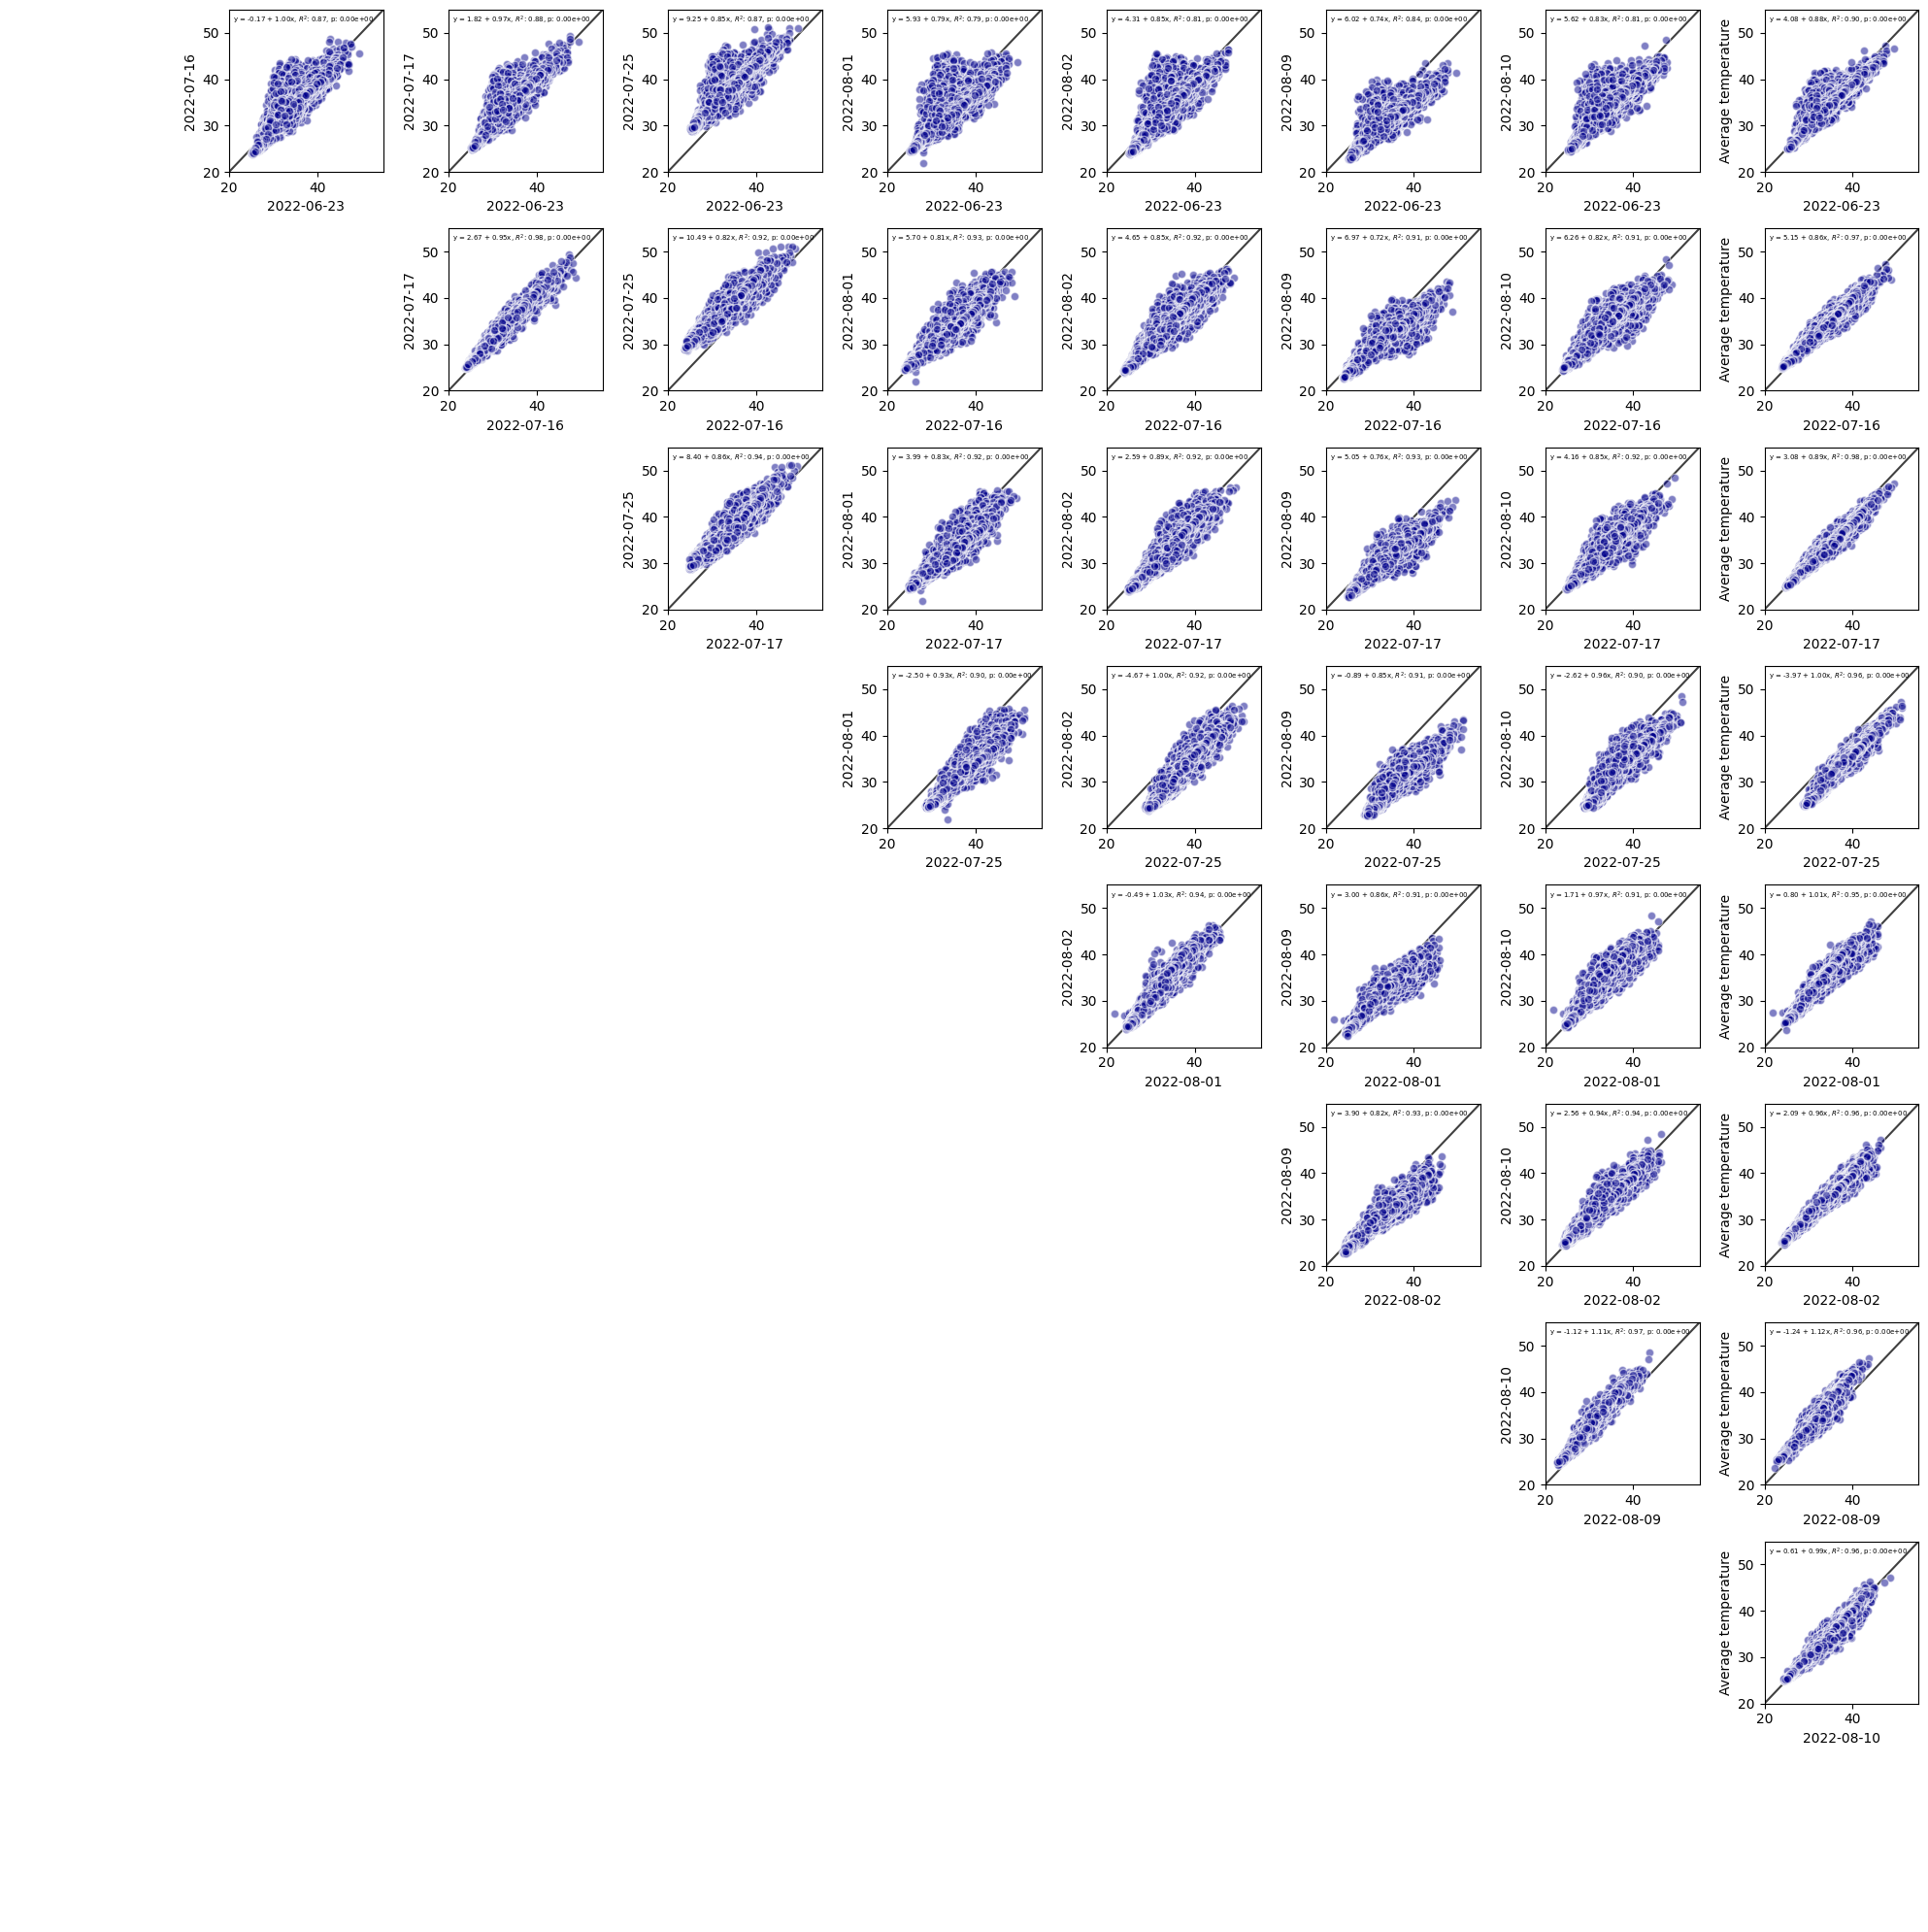

In [208]:
fig, axs = plt.subplots(9, 9, figsize = (20, 20))

titles = {
    '20220623': '2022-06-23', 
    '20220716': '2022-07-16', 
    '20220717': '2022-07-17', 
    '20220725': '2022-07-25', 
    '20220801': '2022-08-01', 
    '20220802': '2022-08-02',
    '20220809': '2022-08-09', 
    '20220810': '2022-08-10', 
    'average_temp': 'Average temperature', 
    'perc_old': 'Percentage inhabitants > 65 yo', 
    'n_old': 'Inhabitants > 65 yo', 
    'n_total': 'Total inhabitants'
}

cols = ('20220623', '20220716', '20220717', '20220725', '20220801', '20220802',
                            '20220809', '20220810', 'average_temp')

done = []

coords = dimensionalIterator((9, 9))
for i, col1 in enumerate(cols):
    for j, col2 in enumerate(cols):
        if set([col1, col2]) not in done:
            if col1 != col2:
                row, col = next(coords)
        
                print(col1, col2)
        
                ax = axs[row][col]
                
                newDf = temps[[col1, col2]]
                newDf = newDf.loc[(newDf[col1] > NODATAVAL) & (newDf[col2] > NODATAVAL)]
                newDf.columns = ['col1', 'col2']

                fit = smf.ols('col2 ~ col1', data=newDf).fit()
                equation = f'y = {fit.params["Intercept"]:.2f} + {fit.params["col1"]:.2f}x'
                r_squared = f'$R^2$: {fit.rsquared:.2f}'
                p_value = f'p: {fit.f_pvalue:.2e}'
                text = f"{equation}, {r_squared}, {p_value}"
                
                ax.plot(newDf['col1'], newDf['col2'], '.', alpha=0.5, markerfacecolor='darkblue')
                ax.plot([20, 55], [20, 55], 'k-', alpha=0.75, zorder=0)
        
                ax.set_xlabel(titles[col1])
                ax.set_ylabel(titles[col2])
                
                ax.set_xlim(20, 55)
                ax.set_ylim(20, 55)

                ax.text(21, 54, text, fontsize=5, horizontalalignment='left', verticalalignment='top')
                
                done.append(set([col1, col2]))
            else:
                row, col = next(coords)
                axs[row][col].set_axis_off()
        else:
            row, col = next(coords)
            axs[row][col].set_axis_off()

plt.tight_layout()
plt.savefig('scatter-comps.pdf')